## Environment prep

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
from math import sqrt, atan2
import pandas as pd
import os

## Load data and get amplitude values

In [ ]:

data_real = []
FILE_NAME = '/content/drive/MyDrive/Wifi_Exercise_Dataset/tvat-raw/tvat-SO-3.csv'
df = pd.read_csv(FILE_NAME)
#df = df.iloc[1:]

for _, row in df.iterrows():
    imaginary = []
    real = []
    amplitudes = []
    phases = []

        # Parse string to create integer list
    csi_string = re.findall(r"\[(.*)\]", row['CSI_DATA'])[0]
    csi_raw = [int(x) for x in csi_string.split(" ") if x != '']

        # Create list of imaginary and real numbers from CSI
    for i in range(len(csi_raw)):
        if i % 2 == 0:
            imaginary.append(csi_raw[i])
        else:
            real.append(csi_raw[i])

        # Transform imaginary and real into amplitude and phase
    for i in range(int(len(csi_raw) / 2)):
        amplitudes.append(sqrt(imaginary[i] ** 2 + real[i] ** 2))
        phases.append(atan2(imaginary[i], real[i]))
    data_real.append(amplitudes)

In [ ]:
amplitude_df = pd.DataFrame(data_real)
print(amplitude_df)
amplitude_df.to_csv('/content/drive/MyDrive/Wifi_Exercise_Dataset/tvat-prep/SO-3-amp.csv',index=False)

              0     1    2    3    4    5          6          7          8   \
0      69.856997   1.0  0.0  0.0  0.0  0.0  13.038405  10.770330   8.246211   
1     164.878743   8.0  0.0  0.0  0.0  0.0  15.556349  16.401219  17.691806   
2     125.876924  23.0  0.0  0.0  0.0  0.0  18.357560  17.464249  18.973666   
3     125.876924  23.0  0.0  0.0  0.0  0.0   3.000000   9.433981   7.071068   
4     126.253713   4.0  0.0  0.0  0.0  0.0   9.848858  14.317821  12.165525   
...          ...   ...  ...  ...  ...  ...        ...        ...        ...   
6717  105.603030   4.0  0.0  0.0  0.0  0.0  19.313208  16.155494  18.601075   
6718  105.603030   4.0  0.0  0.0  0.0  0.0  13.453624  13.601471  11.401754   
6719  105.603030   4.0  0.0  0.0  0.0  0.0  16.278821  23.021729  20.615528   
6720  105.603030   4.0  0.0  0.0  0.0  0.0  18.027756  24.351591  13.000000   
6721  105.603030   4.0  0.0  0.0  0.0  0.0  13.000000  15.524175  14.866069   

             9   ...         54         55         

## Get amplitude values for all files

In [ ]:
folder_path = '/content/drive/MyDrive/Wifi_Exercise_Dataset/tvat-raw'

# List all files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Loop through each file
for file_name in file_list:
    # Construct the full path to the file
    file_path = os.path.join(folder_path, file_name)

    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    data = []
    for _, row in df.iterrows():
      imaginary = []
      real = []
      amplitudes = []
      phases = []

        # Parse string to create integer list
      csi_string = re.findall(r"\[(.*)\]", row['CSI_DATA'])[0]
      csi_raw = [int(x) for x in csi_string.split(" ") if x != '']

        # Create list of imaginary and real numbers from CSI
      for i in range(len(csi_raw)):
          if i % 2 == 0:
              imaginary.append(csi_raw[i])
          else:
              real.append(csi_raw[i])

        # Transform imaginary and real into amplitude and phase
      for i in range(int(len(csi_raw) / 2)):
          amplitudes.append(sqrt(imaginary[i] ** 2 + real[i] ** 2))
          phases.append(atan2(imaginary[i], real[i]))
      data.append(amplitudes)
    temp_df = pd.DataFrame(data)
    temp_df.to_csv(f'/content/drive/MyDrive/Wifi_Exercise_Dataset/tvat-prep/{file_name}-amp.csv',index=False)



## Plot raw  Amplitdue

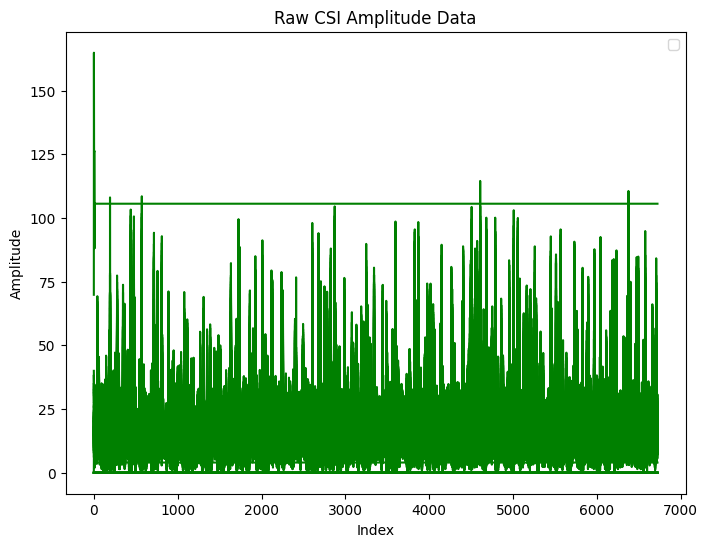

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(amplitude_df,color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title('Raw CSI Amplitude Data')
plt.legend()
plt.show()

## Apply Hampel filter

In [ ]:
pip install hampel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hampel: filename=hampel-1.0.2-cp310-cp310-linux_x86_64.whl size=209427 sha256=0d6db3c4cacbd9405968c3f2f43224ee686b7f3ae3d4c633ca37396438f05ed8
  Stored in directory: /root/.cache/pip/wheels/0e/c3/3c/8a9f55c3de0b09faf919393d4c6f09b11b7421dcaa7243b820
Successfully built hampel


In [ ]:
from hampel import hampel

amp_np = amplitude_df.to_numpy().T

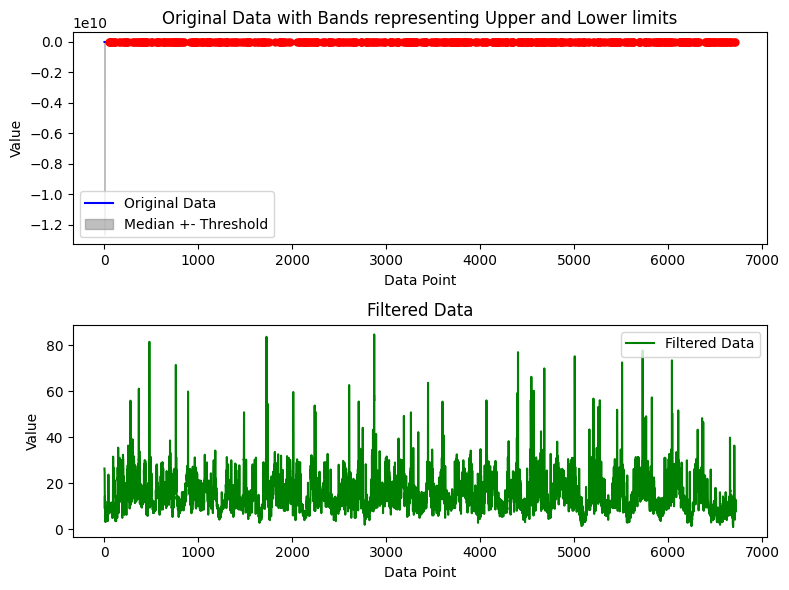

In [ ]:

original_data = amp_np[50]

result = hampel(amp_np[50], window_size=3, n_sigma=5.0)

filtered_data = result.filtered_data
outlier_indices = result.outlier_indices
medians = result.medians
thresholds = result.thresholds

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot the original data with estimated standard deviations in the first subplot
axes[0].plot(original_data, label='Original Data', color='b')
axes[0].fill_between(range(len(original_data)), medians + thresholds, medians - thresholds, color='gray', alpha=0.5, label='Median +- Threshold')
axes[0].set_xlabel('Data Point')
axes[0].set_ylabel('Value')
axes[0].set_title('Original Data with Bands representing Upper and Lower limits')

for i in outlier_indices:
    axes[0].plot(i, original_data[i], 'ro', markersize=5)  # Mark as red

axes[0].legend()

# Plot the filtered data in the second subplot
axes[1].plot(filtered_data, label='Filtered Data', color='g')
axes[1].set_xlabel('Data Point')
axes[1].set_ylabel('Value')
axes[1].set_title('Filtered Data')
axes[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


## Apply Savitzky-Golay filter

In [ ]:
from scipy.signal import savgol_filter


In [ ]:
savgol_filtered = savgol_filter(filtered_data,window_length=5, polyorder=3)

In [ ]:
print(savgol_filtered)

[25.884659 27.243752 21.255    ... 11.368975  8.389767 10.00454 ]


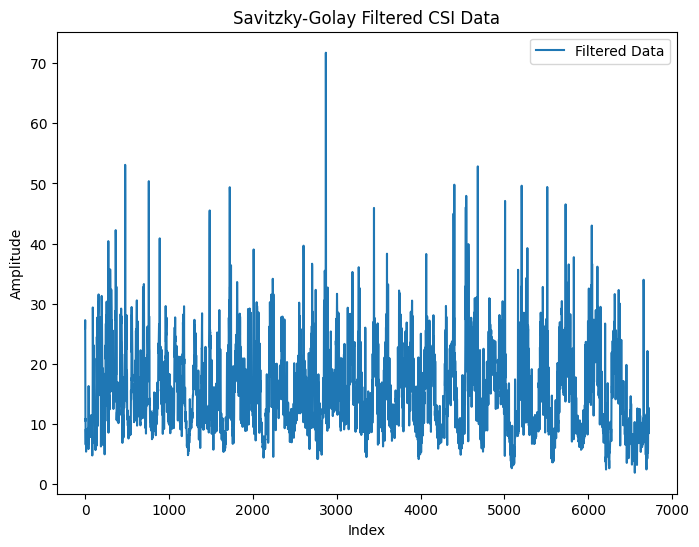

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(savgol_filtered, label='Filtered Data')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title('Savitzky-Golay Filtered CSI Data')
plt.legend()
plt.show()

In [ ]:
export_df = pd.DataFrame(savgol_filtered)
export_df.to_csv('/content/drive/MyDrive/Wifi_Exercise_Dataset/tvat-prep/SO-3-filtered.csv',index=False)